<a target="_blank" href="https://colab.research.google.com/github/Kickstartai-product/kai-tutorials/blob/main/tutorials/efficient_image_annotation_with_Detic/showcase_image_annotation_with_detic.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Set up

## Install dependencies

In [1]:
!pip3 install opencv-python-headless

!pip3 install 'git+https://github.com/facebookresearch/detectron2.git'

!pip3 install ultralytics
!pip3 install transformers

!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
!pip3 install -r "/content/Detic/requirements.txt"

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-cdl82em4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-cdl82em4
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.3 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp310

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 14.5 MB/s eta 0:00:00
Cloning into 'Detic'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 210 (delta 59), reused 56 (delta 56), pack-reused 99 (from 1)
Receiving objects: 100% (210/210), 3.58 MiB | 21.69 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13925, done.        
remote: Counting objects: 100% (948/948), done.        
remote: Compressing objects: 100% (96/96), done.        
remote: Total 13925 (delta 886), reused 858 (delta 850), pack-reused 12977 (from 1) 

## Imports and helper functions


In [2]:
import cv2
import gdown
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch


from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [3]:
original_dir = os.getcwd()

sys.path.insert(0, original_dir + "/Detic/third_party/CenterNet2/")
sys.path.insert(0, original_dir + "/Detic/")

os.chdir(os.path.join(original_dir, "Detic"))

sys.path.insert(0, 'third_party/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test
from detic.modeling.text.text_encoder import build_text_encoder

os.chdir(original_dir)


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [4]:
class DeticDetector:
    def __init__(self, vocabulary=['cardboard box'], device='cpu'):
        os.chdir(os.path.join(original_dir, "Detic"))
        self.cfg = self._setup_cfg(device)
        self.predictor = DefaultPredictor(self.cfg)
        self.metadata = self._setup_metadata(vocabulary)
        self._setup_classifier(vocabulary)
        self.vocabulary = vocabulary
        os.chdir(original_dir)


    def _setup_cfg(self, device):
        cfg = get_cfg()
        add_centernet_config(cfg)
        add_detic_config(cfg)
        cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
        cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
        cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True
        cfg.MODEL.DEVICE = device
        return cfg

    def _setup_metadata(self, vocabulary):
        metadata = MetadataCatalog.get("__unused")
        metadata.thing_classes = vocabulary
        return metadata

    def _setup_classifier(self, vocabulary):
        classifier = self._get_clip_embeddings(vocabulary)
        num_classes = len(vocabulary)
        reset_cls_test(self.predictor.model, classifier, num_classes)
        output_score_threshold = 0.3
        for cascade_stages in range(len(self.predictor.model.roi_heads.box_predictor)):
            self.predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

    def _get_clip_embeddings(self, vocabulary, prompt='a '):
        text_encoder = build_text_encoder(pretrain=True)
        text_encoder.eval()
        texts = [prompt + x for x in vocabulary]
        emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
        return emb

    def detect(self, image_path):
        image = cv2.imread(image_path)
        outputs = self.predictor(image)

        instances = outputs["instances"].to("cpu")
        boxes = instances.pred_boxes.tensor.numpy()
        scores = instances.scores.numpy()
        class_ids = instances.pred_classes.numpy()

        # Convert boxes to COCO format (x_center, y_center, width, height)
        image_height, image_width = image.shape[:2]
        coco_boxes = []
        for box in boxes:
            x1, y1, x2, y2 = box
            x_center = (x1 + x2) / (2 * image_width)
            y_center = (y1 + y2) / (2 * image_height)
            width = (x2 - x1) / image_width
            height = (y2 - y1) / image_height
            coco_boxes.append((x_center, y_center, width, height))

        # Convert class IDs to label strings
        labels = [self.vocabulary[class_id] for class_id in class_ids]

        return coco_boxes, labels, scores.tolist()

    def visualize(self, image_path) -> np.ndarray:
        image = cv2.imread(image_path)
        outputs = self.predictor(image)
        v = Visualizer(image[:, :, ::-1], self.metadata)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        return out.get_image()[:, :, ::-1]


## Mount your Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Download the data

We will store some sample images in a folder called ```data/```


Feel free to manually upload your own images to this folder as well.


In [16]:
!mkdir data
!wget https://github.com/Kickstartai-product/kai-tutorials/blob/main/tutorials/efficient_image_annotation_with_Detic/data/people.jpg?raw=true -O data/people.jpg
!wget https://github.com/Kickstartai-product/kai-tutorials/blob/main/tutorials/efficient_image_annotation_with_Detic/data/helmets.png?raw=true -O data/helmets.png
!wget https://github.com/Kickstartai-product/kai-tutorials/blob/main/tutorials/efficient_image_annotation_with_Detic/data/pencils.png?raw=true -O data/pencils.png
!wget https://github.com/Kickstartai-product/kai-tutorials/blob/main/tutorials/efficient_image_annotation_with_Detic/data/koala.jpg?raw=true -O data/koala.jpg
!wget https://github.com/Kickstartai-product/kai-tutorials/blob/main/tutorials/efficient_image_annotation_with_Detic/data/espeletia.jpg?raw=true -O data/espeletia.jpg


--2024-12-17 13:52:02--  https://github.com/Kickstartai-product/kai-tutorials/blob/main/tutorials/efficient_image_annotation_with_Detic/data/people.jpg?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Kickstartai-product/kai-tutorials/raw/refs/heads/main/tutorials/efficient_image_annotation_with_Detic/data/people.jpg [following]
--2024-12-17 13:52:02--  https://github.com/Kickstartai-product/kai-tutorials/raw/refs/heads/main/tutorials/efficient_image_annotation_with_Detic/data/people.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Kickstartai-product/kai-tutorials/refs/heads/main/tutorials/efficient_image_annotation_with_Detic/data/people.jpg [following]
--2024-12-17 13:52:02--  https://raw.githubusercontent.com/Kickstartai-product/ka

# Select the image and the labels to detect

Feel free to use here your own data as well!

In [17]:
image_file = "/content/data/helmets.png"
labels_to_detect = ["helmet"]

# Run Detic

## initialize DETIC

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

detector = DeticDetector(vocabulary=labels_to_detect, device=device)

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Loading pretrained CLIP


## Detect objects using DETIC

In [19]:
print(f"analysing {image_file}...")
if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
    raise Exception("Only PNG, JPG, and JPEG images are supported")

detected_boxes, detected_labels, probabilities = detector.detect(image_file)

analysing /content/data/helmets.png...


In [20]:
print("Detected boxes:")
print(detected_boxes)

print("\nDetected labels:")
print(detected_labels)

print("\nProbabilities:")
print(probabilities)

Detected boxes:
[(0.4184708463931512, 0.5518239706431916, 0.15405620643478668, 0.23227812839329026), (0.22807260844521893, 0.45074168181161156, 0.17082450090054266, 0.1735430555653486)]

Detected labels:
['helmet', 'helmet']

Probabilities:
[0.7159076929092407, 0.6973159909248352]


 # Generate DETIC visualization

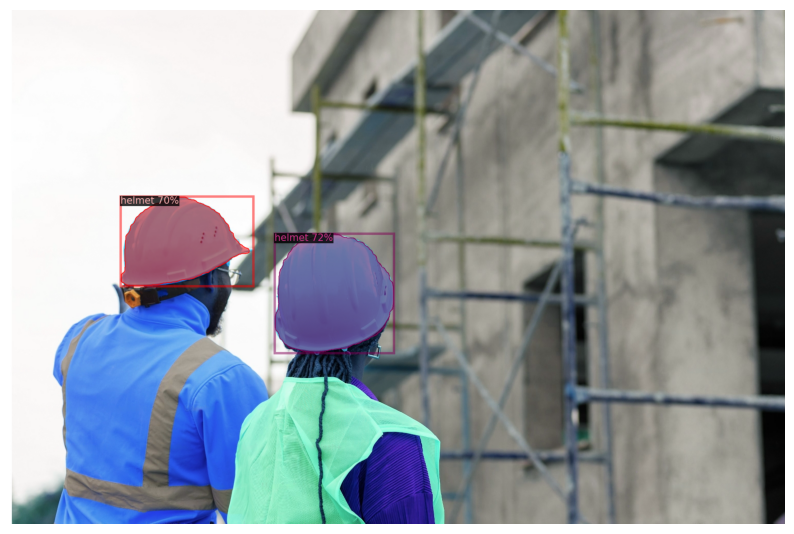

In [21]:
results = detector.visualize(image_file)

plt.figure(figsize=(10, 10))
plt.imshow(results)
plt.axis("off")
plt.show()